**GENAI STATEMENT:**  
I did not use generative AI for this assignment

In [2]:
# import packages:
import re
import boto3
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider

In [2]:
# establish connection

# set to memory and read only false because we are creating new tables:
conn = duckdb.connect(database=':memory:', read_only=False)

# read in each file as a table w/ sql:
db = conn.execute("""
    CREATE TABLE PRESCRIPTIONS AS SELECT * FROM read_csv_auto('../data/PRESCRIPTIONS.csv');
    CREATE TABLE PATIENTS AS SELECT * FROM read_csv_auto('../data/PATIENTS.csv');
    CREATE TABLE ICUSTAYS AS SELECT * FROM read_csv_auto('../data/ICUSTAYS.csv');
    CREATE TABLE DRGCODES AS SELECT * FROM read_csv_auto('../data/DRGCODES.csv');
    CREATE TABLE D_ICD_PROCEDURES AS SELECT * FROM read_csv_auto('../data/D_ICD_PROCEDURES.csv');
    CREATE TABLE PROCEDURES_ICD AS SELECT * FROM read_csv_auto('../data/PROCEDURES_ICD.csv');
    CREATE TABLE ADMISSIONS AS SELECT * FROM read_csv_auto('../data/ADMISSIONS.csv');
""")

# display tables:
conn.sql('SHOW TABLES;')

┌──────────────────┐
│       name       │
│     varchar      │
├──────────────────┤
│ ADMISSIONS       │
│ DRGCODES         │
│ D_ICD_PROCEDURES │
│ ICUSTAYS         │
│ PATIENTS         │
│ PRESCRIPTIONS    │
│ PROCEDURES_ICD   │
└──────────────────┘

We will use a subset of the tables provided in the MIMIC-III database:


*   ADMISSIONS.csv
*   DRGCODES.csv
*   D_ICD_PROCEDURES.csv
*   ICUSTAYS.csv
*   PATIENTS.csv
*   PROCEDURES_ICD.csv
*   PRESCRIPTIONS.csv (new)

***PART ONE: RELATIONAL***

Answer the following analysis questions along with your queries.  
For each question, provide the following four pieces of information:  
> A. the SQL query,  
    B. a brief explanation of the query (i.e., what operations are performed by the major parts of the query),  
    C. the first several lines of your resulting table, and  
    D. a summary of your findings. If it benefits to use a graph, include your graph at the end of your answer, with clear labels and caption.  
  
The analysis questions are:  
> 1. Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.  
> 2. Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.  
> 3. How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?  

In [36]:
# Create a summary of type of drugs and their total amount used by ethnicity. 
# Report the top usage in each ethnicity group (may have to make certain assumptions in calculating their total amount)

# NOTE: hadm_id key for both tables
# create new table with relevant columns joined by hadm_id
conn.sql(
    """
    CREATE TABLE QUESTION01 as
    SELECT 
        A.ethnicity,
        PR.drug_type,
        COUNT(*) AS count, 
    FROM PRESCRIPTIONS PR
    JOIN ADMISSIONS A ON PR.hadm_id = A.hadm_id
    GROUP BY A.ethnicity, PR.drug_type
    """
)

,ethnicity,drug_type,total_use
0,WHITE,MAIN,5420.0
1,WHITE,BASE,1743.0
2,HISPANIC/LATINO - PUERTO RICAN,MAIN,860.0
3,BLACK/AFRICAN AMERICAN,MAIN,476.0
4,HISPANIC/LATINO - PUERTO RICAN,BASE,298.0
5,UNKNOWN/NOT SPECIFIED,MAIN,245.0
6,HISPANIC OR LATINO,MAIN,226.0


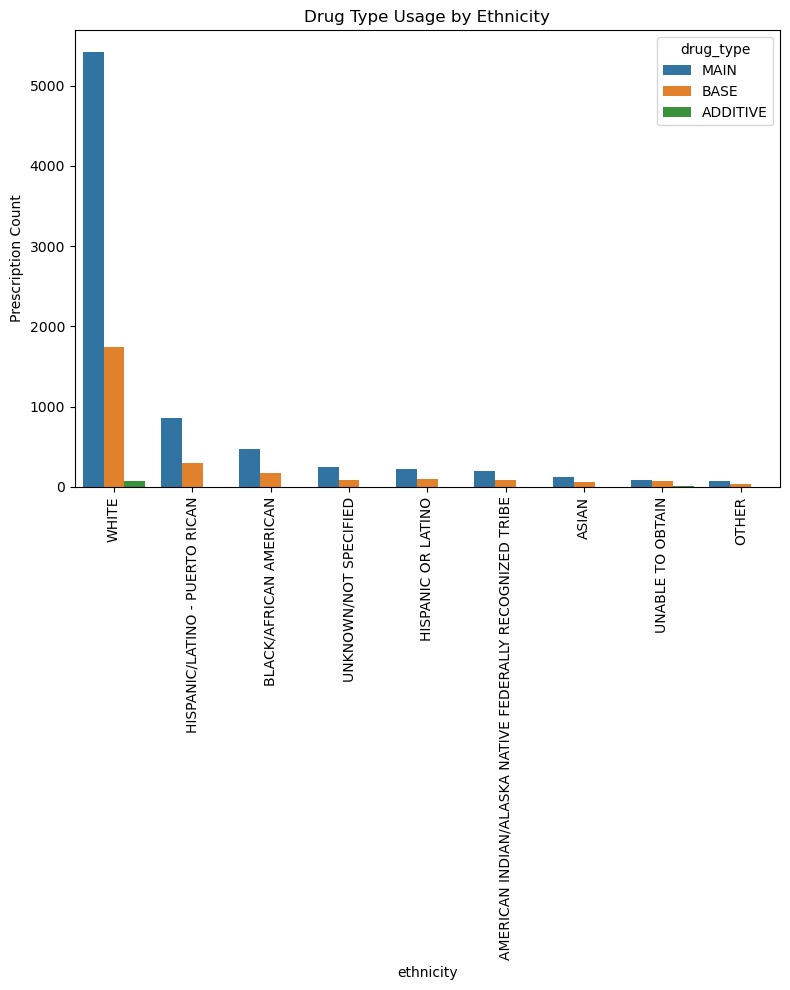

In [50]:
# Find usage by ethnicity:
df1 = conn.sql(
    """
    SELECT ethnicity, drug_type, SUM(count) as total_use FROM QUESTION01
    WHERE drug_type IS NOT NULL
    GROUP BY ethnicity, drug_type
    ORDER BY total_use DESC
    """
    ).df()

# first several lines of resulting table:
display(df1.head(7))

# plot bar chart:
plt.figure(figsize=(8, 10))
sns.barplot(data=df1, x='ethnicity', y='total_use', hue='drug_type')
plt.title("Drug Type Usage by Ethnicity")
plt.xticks(rotation=90)
plt.ylabel("Prescription Count")
plt.tight_layout()
plt.show()

***the top usage in each ethnic group are the main drugs***

In [42]:
# Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80).
# Report the top three procedures, along with the name of the procedures, performed in each age group.

# import relevant columns from respective tables:
    # icd9_code (PROCEDURES_ICD and D_ICD_PROCEDURES), short title (D_ICD_PROCEDURES), subject_ID (PROCEDURES_ICD, PATIENTS and ADMISSIONS), 
    # admittime (ADMISSIONS),  dischtime(PATIENTS), dob (PATIENTS)
conn.sql(
    """
    CREATE TABLE QUESTION02 AS
    SELECT 
        d.short_title,
        a.admittime,
        p.dob,
        NULL AS age_group
    FROM procedures_icd PR
    JOIN d_icd_procedures D ON PR.icd9_code = D.icd9_code
    JOIN admissions A ON PR.hadm_id = A.hadm_id
    JOIN patients P ON A.subject_id = P.subject_id
    """
)

In [ ]:
# to get age, use admit date and dob, convert to date and divide to years:
    # age = ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25)

#  update age_group col:
conn.sql(
    """
    UPDATE QUESTION02
    SET age_group = CASE
        WHEN ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25) <= 19 THEN '<=19'
        WHEN ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25) BETWEEN 20 AND 49 THEN '20-49'
        WHEN ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25) BETWEEN 50 AND 79 THEN '50-79'
        WHEN ROUND(ROUND(CAST(admittime AS DATE) - CAST(dob AS DATE), 1) / 365.25) >= 80 THEN '>=80'
        ELSE 'Unknown'
    END;
    """
)

In [88]:
# get the top three procedures per age group:
df2 = conn.execute(
    """
    WITH procedures_by_age_group AS (
        SELECT age_group, short_title, COUNT(*) AS procedure_count
        FROM QUESTION02
        GROUP BY age_group, short_title
    ),
    ranked AS (
        SELECT *, ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY procedure_count DESC) AS rank
        FROM procedures_by_age_group
    )
    SELECT age_group, short_title, procedure_count
    FROM ranked
    WHERE rank <= 3
    ORDER BY 
        CASE age_group
            WHEN '<=19' THEN 1
            WHEN '20-49' THEN 2
            WHEN '50-79' THEN 3
            WHEN '>=80' THEN 4
            ELSE 6
        END,
        procedure_count DESC
""").df()

display(df2)

,age_group,short_title,procedure_count
0,<=19,Venous cath NEC,2
1,<=19,Spinal tap,1
2,<=19,Packed cell transfusion,1
3,20-49,Venous cath NEC,9
4,20-49,Entral infus nutrit sub,7
5,20-49,Percu abdominal drainage,6
6,50-79,Venous cath NEC,25
7,50-79,Entral infus nutrit sub,22
8,50-79,Packed cell transfusion,13
9,>=80,Venous cath NEC,20


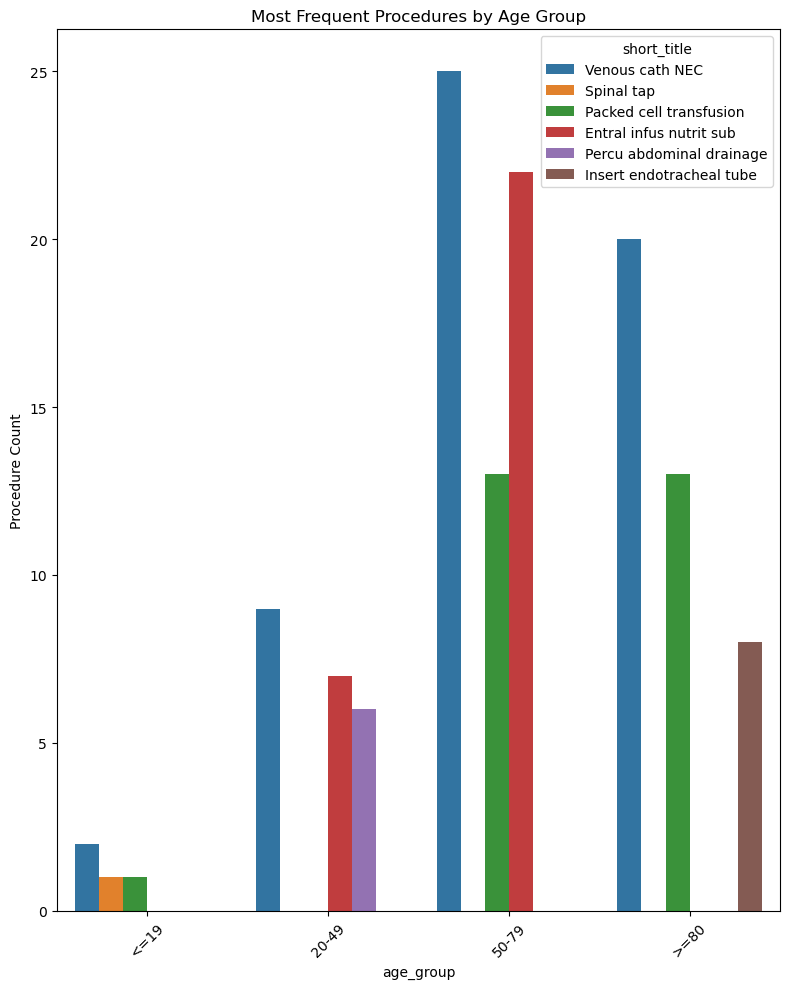

In [90]:
# plot bar chart
plt.figure(figsize=(8, 10))
sns.barplot(data=df2, x='age_group', y='procedure_count', hue='short_title', order = ["<=19", "20-49", "50-79", ">=80"])
plt.title("Most Frequent Procedures by Age Group")
plt.xticks(rotation=45)
plt.ylabel("Procedure Count")
plt.tight_layout()
plt.show()

In [99]:
# How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

# create a table with ICU stay time, gender, and ethnicity:
    # outtime (ICUSTAYS), intime (ICUSTAYS), subject_ID (ADMISSIONS, ICUSTAYS, PATIENTS),
    # ethnicity (ADMISSIONS), gender (PATIENTS)
    # stay_time = outtime - inttime 
conn.execute(""" 
    CREATE TABLE QUESTION03 AS
    SELECT 
        i.intime,
        i.outtime,
        a.ethnicity,
        p.gender, 
        CAST(i.outtime AS DATE) - CAST(i.intime AS DATE) as stay_time_days
    FROM icustays i
    JOIN admissions a ON i.hadm_id = a.hadm_id
    JOIN patients p ON i.subject_id = p.subject_id;
""")

In [107]:
# report how long individuals stay in the ICU in general: average time, range, standard deviation of stays...
conn.execute("""
    SELECT 
        AVG(stay_time_days) AS avg_stay,
        MAX(stay_time_days) - MIN(stay_time_days) AS range_stay,
        STDDEV(stay_time_days) AS stddev_stay
    FROM QUESTION03
""").df()

,avg_stay,range_stay,stddev_stay
0,4.426471,36,6.201114


***The average ICU stay is 4.42 days. The range of stays is 36 days with the maximum stay being 36 days and minimum 0 days.
The standard deviation of stays is 6.2 days***

,ethnicity,stay_time_days,count
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,1,1
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,22,1
2,ASIAN,1,1
3,ASIAN,7,1
4,BLACK/AFRICAN AMERICAN,1,2
5,BLACK/AFRICAN AMERICAN,2,1
6,BLACK/AFRICAN AMERICAN,4,2
7,BLACK/AFRICAN AMERICAN,11,1
8,BLACK/AFRICAN AMERICAN,31,1
9,HISPANIC OR LATINO,3,1


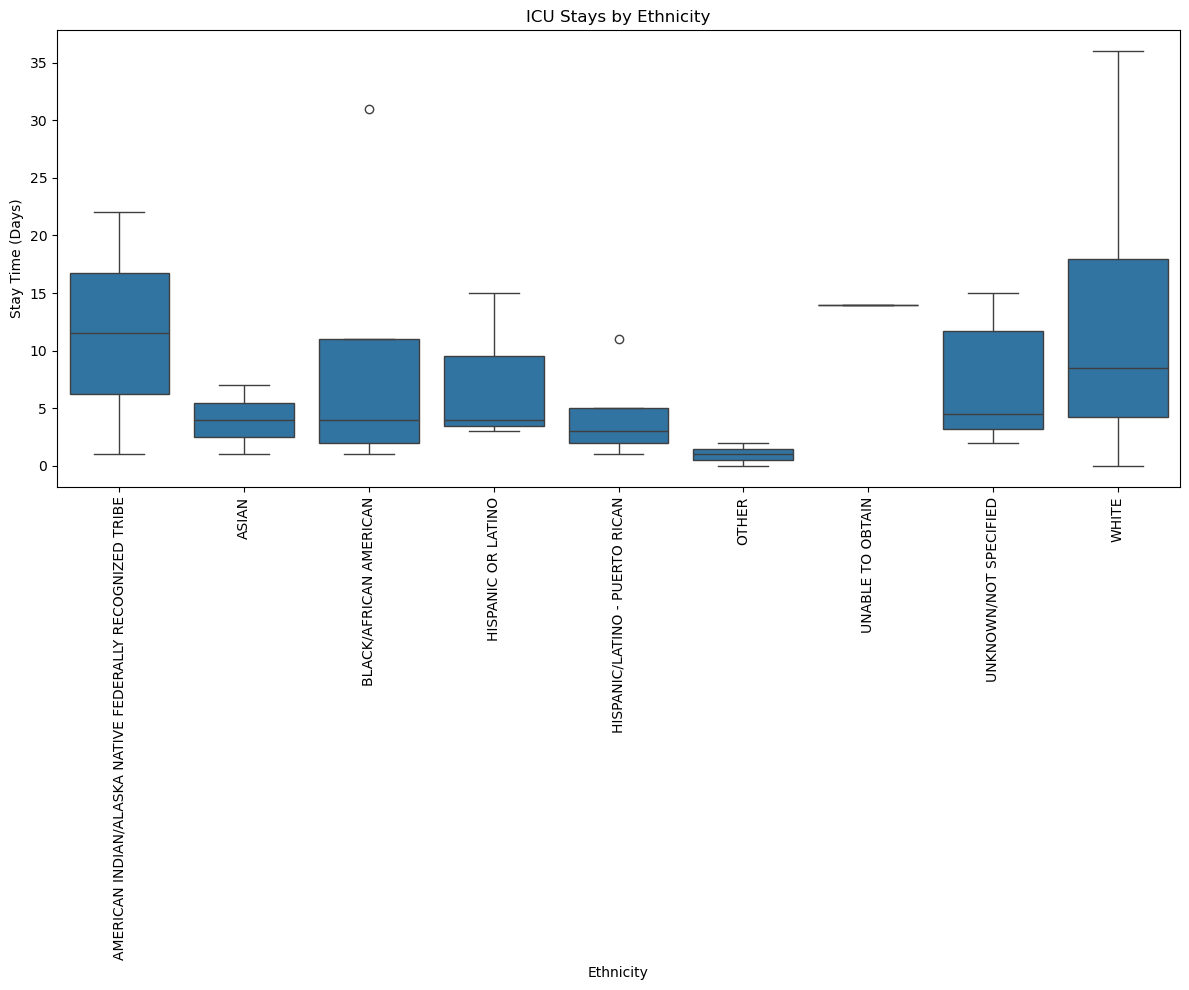

In [119]:
# group stays by ethnicity:
df3e = conn.execute("""
    SELECT ethnicity, stay_time_days, COUNT(*) as count
    FROM QUESTION03
    GROUP BY ethnicity, stay_time_days
    ORDER BY ethnicity, stay_time_days
""").df()

display(df3e.head(10))

# plot stays by ethnicity:
plt.figure(figsize=(12, 10))
sns.boxplot(x='ethnicity', y='stay_time_days', data=df3e)
plt.xticks(rotation=90, ha='center')
plt.title('ICU Stays by Ethnicity')
plt.ylabel('Stay Time (Days)')
plt.xlabel('Ethnicity')
plt.tight_layout()
plt.show()

***Based on the data, there is a difference in length of ICU stay by ethnicity. WHITE and AMERICAN INDIAN ethnicities tend to have the longest stays while OTHER appears to have the shortest stays. PUERTO RICAN and ASIAN ethnicities appear to have the shortest stays besides OTHER.*** 

,gender,stay_time_days,count
0,F,0,1
1,F,1,16
2,F,2,18
3,F,3,7
4,F,4,5
5,F,5,2
6,F,6,1
7,F,7,2
8,F,9,1
9,F,11,1


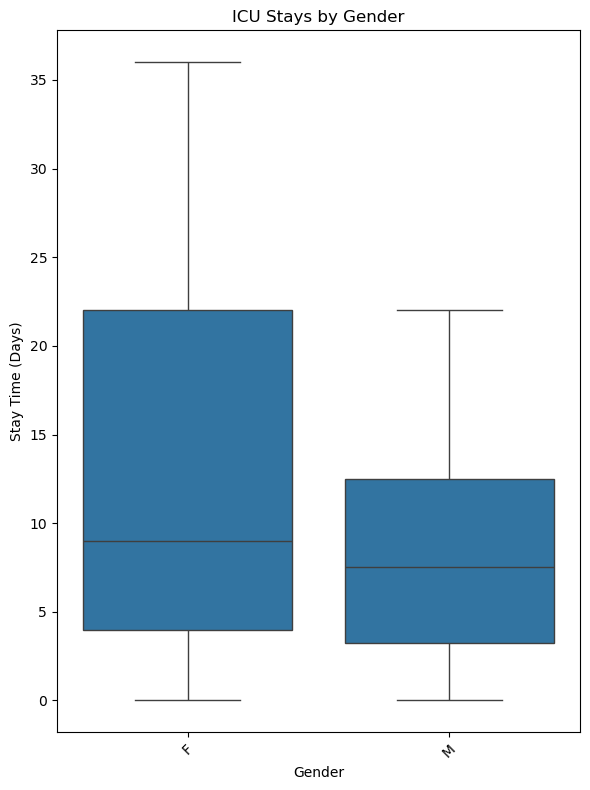

In [121]:
# group stays by gender:
df3e = conn.execute("""
    SELECT gender, stay_time_days, COUNT(*) as count
    FROM QUESTION03
    GROUP BY gender, stay_time_days
    ORDER BY gender, stay_time_days
""").df()

display(df3e.head(10))

# plot stays by ethnicity:
plt.figure(figsize=(6, 8))
sns.boxplot(x='gender', y='stay_time_days', data=df3e)
plt.xticks(rotation=45, ha='center')
plt.title('ICU Stays by Gender')
plt.ylabel('Stay Time (Days)')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

***While the average ICU stay duration is similar between males and females (around 7–8 days), the distribution of stay times differs. Females have a noticeably higher upper quartile, indicating that the longer-stay cases are more common or more extreme in this group. Additionally, the maximum observed stay for females (36 days) is significantly higher than that for males (22 days), suggesting the presence of potential outliers. These outliers may be skewing the distribution for females, even though the average stay remains close to that of males.***

***PART TWO: NON-RELATIONAL***

1. Verify access to Keyspaces via your Jupyter notebook on EC2. Follow the instructions from Keyspace connections lab.
2. Please sign and acknowledge the following statement:
> No copies of the AWS crendentials file is stored on any publicly accessible location, nor is the file in any way shared with anyone outside of DATA_ENG 300 (Spring 2025).

3. For each of the analysis questions above, provide the following four pieces of information:  
    > a. Design a Cassandra table for the specific analysis. Report your table creation query.  
    > b. Upload the data into the table to facilitate answering the question. Report your code for uploading the data.  
    > c. Report the query for extracting relevant data to answer the question. You may choose to not aggregate within Cassandra. If so, indicate your post-extraction analyses and include the code for reaching the final answer.  
    > d. Verify that the extraction produces the desired data.

In [3]:
# set up connection to keyspace:

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

/tmp/ipykernel_245/2577449908.py:4: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
# Create a summary of type of drugs and their total amount used by ethnicity. 
# Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.

In [ ]:
# Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). 
# Report the top three procedures, along with the name of the procedures, performed in each age group.

In [ ]:
# How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?